In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt



In [5]:
#List your tasks here
ds_marker = 'neuro'
tasks = [f'{ds_marker}_top20_spatvar', f'{ds_marker}_top10_spatvar', ds_marker]

task_aliases = {
    f'{ds_marker}_top20_spatvar': 'Top 20 spat.var.met.',
    f'{ds_marker}_top10_spatvar': 'Top 10 spat.var.met.',
    ds_marker: 'All_metabolites'
}
print(tasks, task_aliases)

['neuro_top20_spatvar', 'neuro_top10_spatvar', 'neuro'] {'neuro_top20_spatvar': 'Top 20 spat.var.met.', 'neuro_top10_spatvar': 'Top 10 spat.var.met.', 'neuro': 'All_metabolites'}


                                                     r2       mae      rmse  \
V11L12-038_A1_MOSCOT_paired_hvg_top20_spatvar  0.396777  0.256287  0.339078   
V11L12-038_A1_MOSCOT_paired_hvg_top10_spatvar  0.396777  0.256287  0.339078   
vitatrack                                      0.048502  2.025479  2.699499   

                                                pearson  spearman  
V11L12-038_A1_MOSCOT_paired_hvg_top20_spatvar  0.935038  0.934774  
V11L12-038_A1_MOSCOT_paired_hvg_top10_spatvar  0.935038  0.934774  
vitatrack                                      0.846119  0.905651  


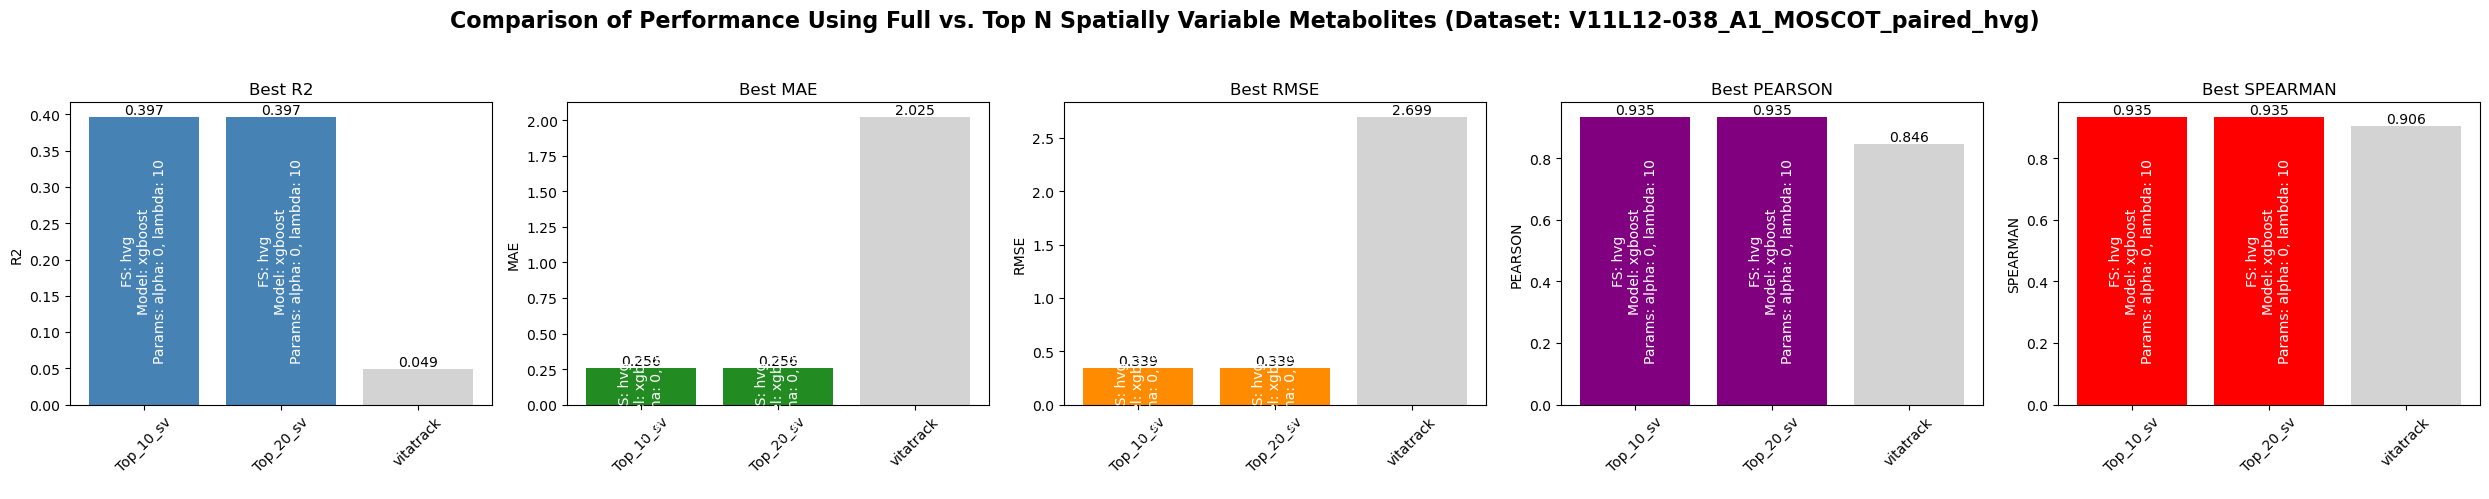

In [23]:
# List your tasks here
ds_marker = 'lipids'
# ds_marker = 'neuro'
ds_marker = "V11L12-038_A1_MOSCOT_paired_hvg"



tasks = [f'{ds_marker}_top20_spatvar', f'{ds_marker}_top10_spatvar', 'vitatrack']

save_directory = '/lustre/groups/ml01/workspace/eirini.giannakoulia/pipeline/visualizations'
filename = f'{ds_marker}_full_vs_spatially_variable_metabolites.png'

task_aliases = {
    f'{ds_marker}_top20_spatvar': 'Top_10_sv',
    f'{ds_marker}_top10_spatvar': 'Top_20_sv',
    ds_marker: 'All_mtblts'
}

base_dir = '/lustre/groups/ml01/workspace/eirini.giannakoulia/pipeline/data/reports'

# Define used metrics
metrics = ['r2', 'mae', 'rmse', 'pearson', 'spearman']
best_direction = {
    'r2': 'max',
    'mae': 'min',
    'rmse': 'min',
    'pearson': 'max',
    'spearman': 'max'
}

# Define highlight colours for the best overall value of each metric.
highlight_colors = {
    'r2': 'steelblue',
    'mae': 'forestgreen',
    'rmse': 'darkorange',
    'pearson': 'purple',
    'spearman': 'red'
}
default_color = 'lightgray'

# Function to extract a short parameter summary (first two key-value pairs)
def get_params_summary(method_params):
    try:
        if not isinstance(method_params, dict):
            params_dict = eval(method_params)
        else:
            params_dict = method_params
        first_items = list(params_dict.items())[:2]
        params_info = ", ".join([f"{k}: {v}" for k, v in first_items])
        return params_info
    except Exception:
        return ""

# Dictionaries to store the best metric values and best method details for each task.
best_values = {}
best_methods = {}

for task in tasks:
    file_path = os.path.join(base_dir, task, 'merged_results.tsv')
    df = pd.read_csv(file_path, sep='\t')
    
    best_values[task] = {}
    best_methods[task] = {}
    
    for metric in metrics:
        # Select the best index based on the desired direction.
        if best_direction[metric] == 'max':
            idx = df[metric].idxmax()
        else:
            idx = df[metric].idxmin()
        best_val = df.loc[idx, metric]
        best_values[task][metric] = best_val
        
        # Get details from the dataframe.
        method_name = df.loc[idx, 'method_name']
        method_params = df.loc[idx, 'method_params']
        featsel_value = df.loc[idx, 'featsel']
        
        # Create a multi-line annotation:
        #  Line 1: FS info
        #  Line 2: Model name
        #  Line 3: Parameters summary (first two key–value pairs)
        params_info = get_params_summary(method_params)
        best_methods[task][metric] = f"FS: {featsel_value}\nModel: {method_name}\nParams: {params_info}"

# Convert the best values dictionary into a DataFrame (tasks as rows, metrics as columns).
best_df = pd.DataFrame.from_dict(best_values, orient='index')
print(best_df)

# Create a subplot for each metric.
num_metrics = len(metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5), squeeze=False)

# Use task aliases (or fall back to original names) for the x-axis labels.
x_labels = [task_aliases.get(task, task) for task in best_df.index]

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    # Determine the overall best value for the current metric.
    if best_direction[metric] == 'max':
        overall_best_value = best_df[metric].max()
    else:
        overall_best_value = best_df[metric].min()

    # Set colours: highlight the best bar.
    colors = [
        highlight_colors[metric] if best_df.loc[task, metric] == overall_best_value else default_color 
        for task in best_df.index
    ]
    
    bars = ax.bar(x_labels, best_df[metric], color=colors)
    
    # Annotate each bar.
    for bar, task in zip(bars, best_df.index):
        height = bar.get_height()
        # Place the best value annotation on top of the bar (outside the bar).
        ax.text(
            bar.get_x() + bar.get_width()/2, height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10, color='black'
        )
        
        # For the best bar, add multi-line annotation inside the bar.
        if height == overall_best_value:
            # Dynamically scale font size based on bar height.
            scale_factor = height / overall_best_value  # equals 1 for the best bar
            adjusted_font_size = max(6, 10 * scale_factor)
            ax.text(
                bar.get_x() + bar.get_width()/2, height/2,
                best_methods[task][metric],
                ha='center', va='center', fontsize=adjusted_font_size,
                color='white', rotation=90
            )
    
    ax.set_title(f"Best {metric.upper()}")
    ax.set_ylabel(metric.upper())
    # Rotate x-axis labels 45 degrees.
    ax.tick_params(axis='x', labelrotation=45)

# Update the main title to include the dataset task.
plt.suptitle(
    f"Comparison of Performance Using Full vs. Top N Spatially Variable Metabolites (Dataset: {ds_marker})",
    fontsize=16, fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])  # Adjust layout to fit the title
full_path = os.path.join(save_directory, filename)
os.makedirs(save_directory, exist_ok=True)
plt.savefig(full_path, dpi=300, bbox_inches='tight')

plt.show()
